# 2-qubitでは|01>が大きくなった。→3 qubitにしたらどうなる？

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, execute, transpile, Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
from qiskit.compiler import transpile

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_23354/3835349950.py:14: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


In [24]:
def trotter_gate(dt, to_instruction = True):
    qc = QuantumCircuit(2)
    qc.h(1)
    qc.cx(1,0)
    qc.rx(dt, 1)
    qc.rz(- dt, 1)
    qc.rz(dt, 0)
    qc.cx(1,0)
    qc.h(1)
    qc.rx(dt, [1])

    qc.rz(-dt, [0,1])
    qc.rx(-dt, [0,1])
    return qc.to_instruction() if to_instruction else qc

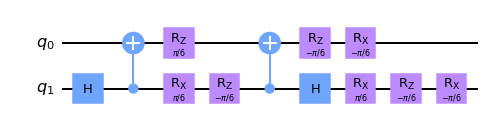

In [25]:
trotter_gate(np.pi / 6, to_instruction=False).draw("mpl")

In [4]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

# Parameterize variable t to be evaluated at t=pi later
dt = Parameter('t')
# Convert custom quantum circuit into a gate
Trot_gate = trotter_gate(dt)

# YOUR TROTTERIZATION GOES HERE -- FINISH (end of example)

In [5]:
# The final time of the state evolution
target_time = np.pi

# Number of trotter steps
trotter_steps = 4  ### CAN BE >= 4

# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr, cr)

In [6]:
# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
# init state |10> (= |110>)
qc.x(1)  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

# Simulate time evolution under H_heis3 Hamiltonian
for _ in range(trotter_steps):
    qc.append(Trot_gate, [qr[1], qr[2]])

qc.cx(qr[1], qr[0])
qc.cx(qr[2], qr[1])
    
# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.bind_parameters({dt: target_time / trotter_steps})

In [7]:
qc.measure(qr, cr)

In [8]:
t0_qc = transpile(qc, optimization_level=0, basis_gates=["sx","rz","cx"])
# t0_qc.draw("mpl")

In [9]:
t0_qc = t0_qc.reverse_bits()
# t0_qc.draw("mpl")

In [10]:
shots = 8192
reps = 1

# WE USE A NOISELESS SIMULATION HERE
backend = Aer.get_backend('qasm_simulator')

In [11]:
jobs = []
for _ in range(reps):
    # execute
    job = execute(t0_qc, backend=backend, shots=shots, optimization_level=0)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 779d7bd5-28dd-48b4-b15a-c2055b70f6d4


In [20]:
counts_110 = []
# counts_10 = []
for trotter_steps in range(1, 15, 1):
    
    print("number of trotter steps: ", trotter_steps)
    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(3)
    cr = ClassicalRegister(3)
    qc = QuantumCircuit(qr, cr)
    
    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    # init state |10> (= |110>)
    qc.x(1)  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(0, trotter_steps + 1):
        qc.append(Trot_gate, [qr[1], qr[2]])
        
    qc.cx(qr[1], qr[0])
    qc.cx(qr[2], qr[1])

    # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
    qc = qc.bind_parameters({dt: target_time / trotter_steps})
    t0_qc = transpile(qc, optimization_level=0, basis_gates=["sx","rz","cx"])
    t0_qc = t0_qc.reverse_bits()
    t0_qc.measure(qr, cr)
    print("circuit depth: ", t0_qc.depth())
    
    job = execute(t0_qc, backend=backend, shots=shots, optimization_level=0)
    print("pribability distribution: ", job.result().get_counts())
    
    counts_110.append(job.result().get_counts().get("110", 0))
    # counts_10.append(job.result().get_counts().get("10", 0))
    print()

number of trotter steps:  1
circuit depth:  56
pribability distribution:  {'110': 8192}

number of trotter steps:  2
circuit depth:  82
pribability distribution:  {'000': 4106, '011': 4086}

number of trotter steps:  3
circuit depth:  108
pribability distribution:  {'110': 793, '011': 1801, '101': 3905, '000': 1693}

number of trotter steps:  4
circuit depth:  134
pribability distribution:  {'011': 1524, '000': 897, '110': 1245, '101': 4526}

number of trotter steps:  5
circuit depth:  160
pribability distribution:  {'000': 942, '011': 1915, '110': 1264, '101': 4071}

number of trotter steps:  6
circuit depth:  186
pribability distribution:  {'101': 3877, '110': 1251, '011': 1996, '000': 1068}

number of trotter steps:  7
circuit depth:  212
pribability distribution:  {'110': 1144, '011': 1937, '000': 1397, '101': 3714}

number of trotter steps:  8
circuit depth:  238
pribability distribution:  {'110': 1187, '011': 1864, '101': 3605, '000': 1536}

number of trotter steps:  9
circuit de

Text(0.5, 1.0, 'counts of |110>')

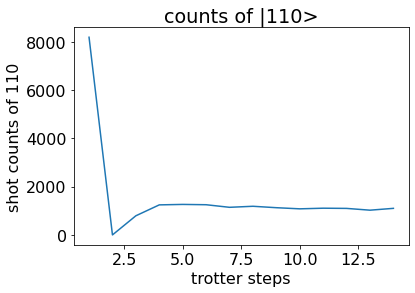

In [21]:
plt.plot(range(1,15), counts_110)
plt.xlabel("trotter steps")
plt.ylabel("shot counts of 110")
plt.title("counts of |110>")

Text(0.5, 1.0, 'counts of |01>')

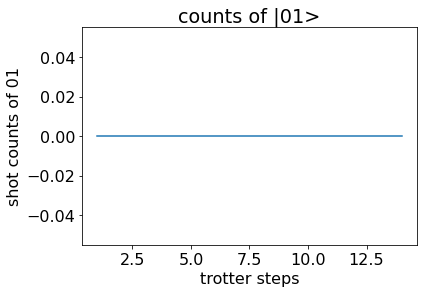

In [15]:
plt.plot(range(1,15), counts_01)
plt.xlabel("trotter steps")
plt.ylabel("shot counts of 01")
plt.title("counts of |01>")